In [1]:
## cetin ilhan kaya phys710 exam Question 1 Tasks 2&3

import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt
from torch import concat, tensor
from numpy.linalg import LinAlgError
np.random.seed(31)

In [2]:
geo_file = 'files/h2.xyz'

symbols, coordinates = qml.qchem.read_structure(geo_file)
hamiltonian, qubits = qml.qchem.molecular_hamiltonian(symbols, coordinates)


<class 'pennylane.ops.qubit.hamiltonian.Hamiltonian'>


In [3]:
dev = qml.device('default.qubit', wires = qubits)
hf_state = np.array([1,1,0,0], requires_grad=False)

def ansatz(params, wires=[0,1,2,3]):
    qml.BasisState(hf_state, wires=wires)
    for i in wires:
        qml.RZ(params[3*i] , wires=i)
        qml.RY(params[3*i+1] , wires=i)
        qml.RZ(params[3*i+2] , wires=i)
    qml.CNOT(wires=[2,3])
    qml.CNOT(wires=[2,0])
    qml.CNOT(wires=[3,1])
    
@qml.qnode(dev)
def cost(params):
    ansatz(params)
    return qml.expval(hamiltonian)

exact_value = -1.136189454088

<class 'pennylane.qnode.QNode'>


In [4]:

init_params = np.random.uniform(low=0, high=2*np.pi, size=12, requires_grad=True)
max_iter = 500
step_size = 0.1 #here i choose to decrease it to 0.1 because 0.5 step size causes qng to deviate from the exac_value
conv_tol = 1e-06
n_iter = 0
liste = []
bad_choices=[]
good_choices=[]

In [5]:
%%time
# gradient-descent optimizer
gde_optimizer = qml.GradientDescentOptimizer(stepsize=step_size)
theta_gde = init_params
gde_cost = [cost(theta_gde)]
angle_gde = [theta_gde]
for i in range(max_iter):
    theta_gde, last_cost = gde_optimizer.step_and_cost(cost, theta_gde)
    gde_cost.append(cost(theta_gde))
    angle_gde.append(theta_gde)
    
    conv = np.abs(gde_cost[-1] - last_cost)
    if i%10==0:
        print(f'step = {i}, cost function = {gde_cost[-1]:.8f}')
    if conv <= conv_tol:
        n_iter = i
        break
    else:
        n_iter=max_iter
gde_acc = 100*(1 - abs((exact_value - gde_cost[-1] )/exact_value)) #gde accuracy

print('\n' f'final value of the cost function = {gde_cost[-1]:.8f}')
print('\n' 'number of iterations=',n_iter)
print('\n' f'optimal value of the first circuit parameter = ' + str(angle_gde[-1][0]))
print('\n' f'optimal value of the second circuit parameter = ' + str(angle_gde[-1][1]))
print(f'accuracy of gde: ', gde_acc)

step = 0, cost function = -0.04571280
step = 10, cost function = -0.13723717
step = 20, cost function = -0.20793398
step = 30, cost function = -0.26114249
step = 40, cost function = -0.30072848
step = 50, cost function = -0.33139166
step = 60, cost function = -0.35686630
step = 70, cost function = -0.37915079
step = 80, cost function = -0.39890720
step = 90, cost function = -0.41613955
step = 100, cost function = -0.43070921
step = 110, cost function = -0.44260113
step = 120, cost function = -0.45198945
step = 130, cost function = -0.45919138
step = 140, cost function = -0.46458811
step = 150, cost function = -0.46855816
step = 160, cost function = -0.47143751
step = 170, cost function = -0.47350345
step = 180, cost function = -0.47497385
step = 190, cost function = -0.47601410
step = 200, cost function = -0.47674677
step = 210, cost function = -0.47726111
step = 220, cost function = -0.47762130
step = 230, cost function = -0.47787310
step = 240, cost function = -0.47804890
step = 250,

In [6]:
# QNG
qng_costs = []
qng_accuracy = []

def QNG(params, stepsize, cost_funct):
    qng_optimizer = qml.QNGOptimizer(stepsize=step_size, approx='block-diag')
    theta_qng = params
    Hamiltonian = qml.Hamiltonian(np.array(hamiltonian.coeffs, requires_grad=False), hamiltonian.ops)
    qng_cost = [cost(theta_qng)]
    qng_costs.append(qng_cost)
    angle_qng = [theta_qng]


    for i in range(max_iter):
        adj_metric_tensor = qml.adjoint_metric_tensor(cost, cost.device)
        theta_qng, last_cost = qng_optimizer.step_and_cost(cost, theta_qng, metric_tensor_fn=adj_metric_tensor)
        qng_cost.append(cost(theta_qng))
        angle_qng.append(theta_qng)
        qng_acc =  100*(1 - abs((exact_value - qng_cost[-1] )/exact_value)) #qng accuracy
        qng_accuracy.append(qng_acc)
    
        conv = np.abs(qng_cost[-1] - last_cost)
        if i%10==0:
            print(f'step = {i}, cost function = {qng_cost[-1]:.8f}')
            
        if conv <= conv_tol:
            n_iter = i
            break 
        else:
            n_iter = max_iter
        
    
    print('\n', len(qng_costs))
    print('\n' f'final value of the cost function = {qng_cost[-1]:.8f}')
    print('\n' 'number of iterations=',n_iter)
    print('\n' f'accuracy of Quantum Natural Gradient= ', qng_acc)


In [7]:
%%time
try:
    QNG(init_params, step_size, cost)
except LinAlgError as err:
    print('initial values caused QNG fail')


print('\n','Note that QNG achieves greater accuracy with less iterations compared to GDE for 0.1 step size')
print('with 0.5 step size, QNG deviates from the exact_value such that in one test, cost was -0.7 which is unacceptable')

step = 0, cost function = -0.07713108
step = 10, cost function = -0.34020072
step = 20, cost function = -0.43722973
step = 30, cost function = -0.46797673
step = 40, cost function = -0.47599457
step = 50, cost function = -0.47789314
step = 60, cost function = -0.47832675
step = 70, cost function = -0.47842463
step = 80, cost function = -0.47844666

 1

final value of the cost function = -0.47844755

number of iterations= 81

accuracy of Quantum Natural Gradient=  42.10983869551291

 Note that QNG achieves greater accuracy with less iterations compared to GDE for 0.1 step size
with 0.5 step size, QNG deviates from the exact_value such that in one test, cost was -0.7 which is unacceptable
Wall time: 14 s


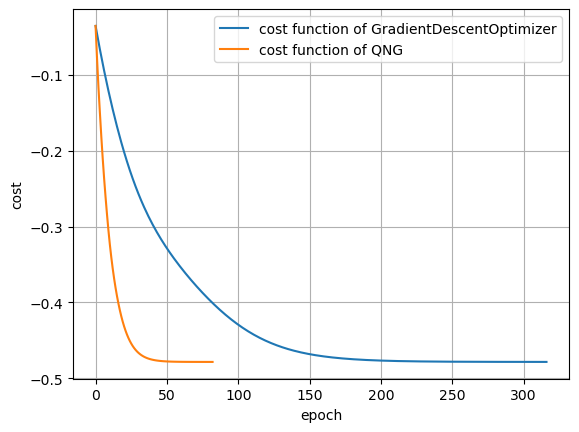

In [8]:
def plot(gde_cost,qng_cost):
    plt.plot(gde_cost, label='cost function of GradientDescentOptimizer')
    plt.plot(qng_costs[-1], label='cost function of QNG')
    plt.xlabel('epoch')
    plt.ylabel('cost')
    plt.legend()
    plt.grid(True)
plot(gde_cost, qng_costs)

In [9]:
%%time


for i in range(10):
    new_params = np.random.uniform(low=0, high=2*np.pi, size=12)
    liste.append(new_params)

for i in range(len(liste)):
    print('length of liste: ', len(liste))
    print('\n' f'training #{i+1} starts with new param = ', liste[i])
    try:
        QNG(liste[i], step_size, cost)

    except LinAlgError as err:
        print(f'initial value causing singular matrix: {liste[i]}')
        bad_choices.append(liste[i])
    if qng_accuracy[i] < 0.8:
        bad_choices.append(liste[i])
    else:
        good_choices.append(liste[i])


length of liste:  10

training #1 starts with new param =  [0.27618563 1.22073487 2.80644431 0.3931595  1.86967037 5.92900781
 1.7769544  1.68196816 2.55863246 5.18985076 3.18369416 1.69316375]
step = 0, cost function = -0.16294373
step = 10, cost function = -0.27610673
step = 20, cost function = -0.39709456
step = 30, cost function = -0.45277101
initial value causing singular matrix: [0.27618563 1.22073487 2.80644431 0.3931595  1.86967037 5.92900781
 1.7769544  1.68196816 2.55863246 5.18985076 3.18369416 1.69316375]
length of liste:  10

training #2 starts with new param =  [2.13746605 6.12278722 1.15801982 1.52224096 4.33828382 2.41233649
 2.89932844 4.24256372 0.53866127 1.47036996 3.28270595 0.43427288]
step = 0, cost function = 0.00157344
step = 10, cost function = -0.18504929
step = 20, cost function = -0.33204778
step = 30, cost function = -0.39604550
step = 40, cost function = -0.45195368
step = 50, cost function = -0.60269370
step = 60, cost function = -0.97403034
step = 70, c

11


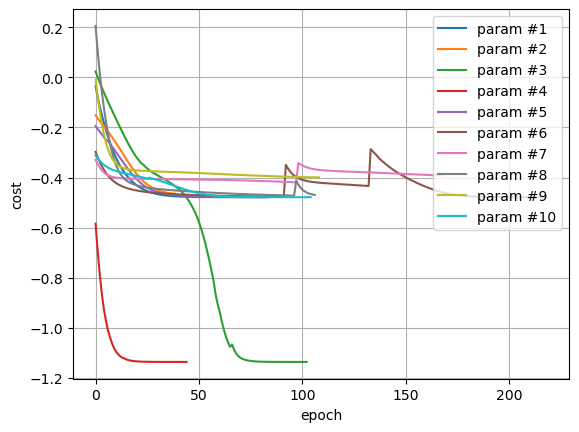

In [10]:
print(len(qng_costs))
#plot the cost function wrt different initial parameters
def plotter():
    for i in range(len(liste)):
        plt.plot(qng_costs[i], label=f'param #{i+1}')
        plt.xlabel('epoch')
        plt.ylabel('cost')
        plt.grid(True)
        plt.legend()
        plt.plot()
plotter()

print('as we can see in the graph, some initial values results in good results,')
print('and some causes algorithm to halt. check if there is a correlation in between in the next part')

In [11]:
print(f'bad values to begin with: \n', bad_choices)
print(f'\n good values to begin with: \n', good_choices)

bad values to begin with: 
 [tensor([0.27618563, 1.22073487, 2.80644431, 0.3931595 , 1.86967037,
        5.92900781, 1.7769544 , 1.68196816, 2.55863246, 5.18985076,
        3.18369416, 1.69316375], requires_grad=True), tensor([1.90827834, 1.89605718, 0.0464134 , 3.64087571, 4.51332551,
        2.55891193, 1.02393427, 1.32139583, 4.77599383, 2.24804924,
        2.43191401, 4.73704142], requires_grad=True), tensor([5.45026456, 4.71003161, 2.49716292, 2.63943962, 3.47821939,
        2.9247158 , 5.41339854, 5.17567119, 0.46523524, 2.01475981,
        2.64136324, 4.15533503], requires_grad=True), tensor([3.96791461, 3.23690291, 2.22140182, 0.26536066, 0.23198806,
        4.90249614, 1.13243455, 2.53150229, 5.18709742, 2.75855841,
        3.40872728, 0.096115  ], requires_grad=True), tensor([2.71546381, 2.91618953, 2.00273091, 3.88823591, 1.45143307,
        0.95324882, 2.35559277, 3.98093808, 2.26231065, 3.46831966,
        4.91506222, 4.28698633], requires_grad=True), tensor([5.6825754 , 4

In [12]:
#check if there are correlation between good or bad choices of hyperparameters
'''closer to 1, stronger the correlations
closer to -1, stronger the anticorrelations
closer to 0, means no correlations'''
from numpy import corrcoef, mean
def printer(correlation,mean):
    if str(correlation) == 'goodcorrelation':
        x=str('good')
    else:
        x=str('bad')
    if mean>0.7:
        print(f'{mean} means there are correlations between columns of {x} choice matrix')
    elif mean<-0.7:
        print(f'{mean} means there are anticorrelations between columns of {x} choice matrix')
    else:
        print(f'{mean} means there are nearly no correlations because it is closer to 0')
badcorrelation = corrcoef(bad_choices)
print('correlation matrix for bad choices: \n',badcorrelation)
meanc = mean(badcorrelation)
print('\n overall mean of bad correlation matrix \n', meanc)
printer(badcorrelation, meanc)

goodcorrelation = corrcoef(good_choices)
print('\n correlation matrix for guud choices: \n',goodcorrelation)
meang = mean(goodcorrelation)
print('\n overall mean of bad correlation matrix: \n',meang)
printer(goodcorrelation, meang)

correlation matrix for bad choices: 
 [[ 1.         -0.08156612 -0.49175715  0.43096052 -0.2821863  -0.55581566
  -0.60217873]
 [-0.08156612  1.         -0.39285007 -0.16788043  0.06232433 -0.00652752
   0.4002431 ]
 [-0.49175715 -0.39285007  1.         -0.29311613  0.09356348  0.36315001
   0.30581903]
 [ 0.43096052 -0.16788043 -0.29311613  1.         -0.25225922 -0.13898404
  -0.80131211]
 [-0.2821863   0.06232433  0.09356348 -0.25225922  1.         -0.33050381
   0.16589795]
 [-0.55581566 -0.00652752  0.36315001 -0.13898404 -0.33050381  1.
   0.48553406]
 [-0.60217873  0.4002431   0.30581903 -0.80131211  0.16589795  0.48553406
   1.        ]]

 overall mean of bad correlation matrix 
 0.057573680829051725
0.057573680829051725 means there are nearly no correlations because it is closer to 0

 correlation matrix for guud choices: 
 [[ 1.00000000e+00 -1.83660990e-01 -9.09463563e-02 -8.15661232e-02
  -4.91757154e-01  4.30960520e-01 -2.82186303e-01 -5.55815660e-01
   2.34789658e-01 -6.02

<AxesSubplot:>

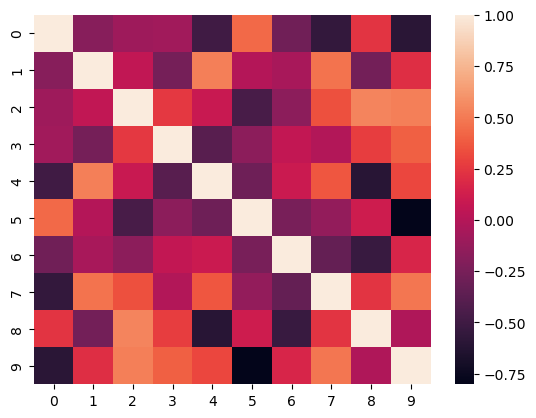

In [13]:
import seaborn as sns
import pandas as pd
gc = pd.DataFrame(goodcorrelation)
sns.heatmap(gc, xticklabels=gc.columns, yticklabels=gc.columns)